In [1]:
# default_exp inferno

In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

# INFERNO loss

> API details.

In [3]:
#hide
from nbdev.showdoc import *

In [4]:
from pytorch_inferno.model_wrapper import ModelWrapper
from pytorch_inferno.callback import *
from pytorch_inferno.data import get_paper_data
from pytorch_inferno.plotting import *
from pytorch_inferno.inference import *
from pytorch_inferno.utils import *

from fastcore.all import partialler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from typing import *
from collections import OrderedDict
from fastcore.all import store_attr
from abc import abstractmethod

import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import torch
from torch import Tensor
from torch import autograd

# Network

In [5]:
bs = 2000
data, test = get_paper_data(200000, bs=bs, n_test=1000000)

In [6]:
# export
class VariableSoftmax(nn.Softmax):
    def __init__(self, temp:float=1, dim:int=-1):
        super().__init__(dim=dim)
        self.temp = temp
        
    def forward(self, x:Tensor) -> Tensor: return super().forward(x/self.temp)

In [7]:
x = torch.randn((1,10))

In [8]:
VariableSoftmax(0.1)(x), VariableSoftmax(0.5)(x), VariableSoftmax(1)(x)

(tensor([[6.0802e-12, 7.6036e-09, 5.5408e-15, 4.0649e-07, 2.5433e-09, 6.4091e-08,
          1.0000e+00, 8.7659e-18, 1.3295e-12, 9.2868e-11]]),
 tensor([[4.9515e-03, 2.0614e-02, 1.2209e-03, 4.5684e-02, 1.6559e-02, 3.1573e-02,
          8.6687e-01, 3.3613e-04, 3.6534e-03, 8.5413e-03]]),
 tensor([[0.0376, 0.0767, 0.0187, 0.1142, 0.0688, 0.0950, 0.4976, 0.0098, 0.0323,
          0.0494]]))

In [9]:
net = nn.Sequential(nn.Linear(3,100),  nn.ReLU(),
                    nn.Linear(100,100),nn.ReLU(),
                    nn.Linear(100,10), VariableSoftmax(0.1))
init_net(net)

# Loss

In [10]:
x,y,w = next(iter(data.trn_dl))
preds = net(x)
assert preds.shape == (bs,10)

In [11]:
def to_shape(p:Tensor) -> Tensor:
    f = p.sum(0)
    f = f/f.sum()
    return f

In [12]:
m = y.squeeze()==0
f_s = to_shape(preds[~m])
f_b = to_shape(preds[m])

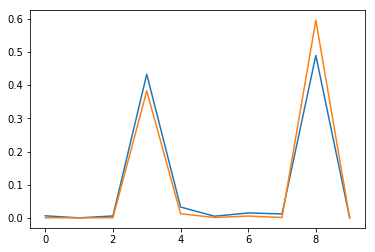

In [13]:
plt.plot(to_np(f_s))
plt.plot(to_np(f_b))

## Minimise width

with torch.no_grad():
    u,d = [],[]
    b = x[m]
    b[:,0] += 0.2
    u.append(to_shape(net(b)))
    b[:,0] -= 0.2
    b[:,2] *= 3.5/3
    u.append(to_shape(net(b)))
    b[:,2] /= 3.5/3
    b[:,0] -= 0.2
    d.append(to_shape(net(b)))
    b[:,0] += 0.2
    b[:,2] *= 2.5/3
    d.append(to_shape(net(b)))
    b[:,2] /= 2.5/3
    b_up,b_dw = torch.stack(u),torch.stack(d)

nll,alpha = calc_profile(f_s=f_s, f_b_nom=f_b, f_b_up=b_up, f_b_dw=b_dw, verbose=False, n=1050, mu_scan=torch.linspace(20,80,61), true_mu=50)

nll

plot_likelihood(to_np(nll-nll[nll==nll].min()))

nll = nll-nll[nll==nll].min()-0.5

nll

plot_likelihood(to_np(nll))

nll.max()-nll.min()

def get_diff_width(nll:Tensor, mu_scan:np.ndarray) -> Tensor:
    def lin_root(nll0,nll1,mu0,mu1):
        a = (nll1-nll0)/(mu1-mu0)
        b = nll1-(a*mu1)
        return -b/a
    
    u,r,last_mu,last_nll = True,torch.zeros((2)),mu_scan[0],nll[0]

    for mu,l in zip(mu_scan[1:],nll[1:]):
        if u and l < 0:
            r[0] = lin_root(last_nll,l,last_mu,mu)
            u = False
        elif not u and l > 0:
            r[1] = lin_root(last_nll,l,last_mu,mu)
            break
        if l == l: last_mu,last_nll = mu,l
    return r[1]-r[0]

w = get_diff_width(nll, mu_scan=np.linspace(20,80,61)); w

class AbsInferno(AbsCallback):
    def __init__(self, n:int, mu_scan:Tensor, true_mu:int, n_steps:int=100, lr:float=0.1):
        super().__init__()
        store_attr()
        
    def on_train_begin(self) -> None:
        r'''
        Fake loss function, callback computes loss in `on_forwards_end`
        '''
        self.wrapper.loss_func = lambda x,y: None
        self.profiler = partialler(calc_profile, n=self.n, mu_scan=to_device(self.mu_scan, self.wrapper.device), true_mu=self.true_mu,
                                   n_steps=self.n_steps, lr=self.lr, verbose=False)
        
    @staticmethod
    def _to_shape(p:Tensor) -> Tensor:
        f = p.sum(0)
        f = f + 1e-7
        f = f/f.sum()
        return f
    
    @abstractmethod
    def _get_up_down(self, x:Tensor) -> Tuple[Tensor,Tensor]: pass
        
    def _get_diff_width(self, nll:Tensor) -> Tensor:
        def lin_root(nll0,nll1,mu0,mu1):
            a = (nll1-nll0)/(mu1-mu0)
            b = nll1-(a*mu1)
            return -b/a

        u,r,last_mu,last_nll = True,torch.zeros((2)),self.mu_scan[0],nll[0]
        for mu,l in zip(self.mu_scan[1:],nll[1:]):
            if u and l < 0:
                r[0] = lin_root(last_nll,l,last_mu,mu)
                u = False
            elif not u and l > 0:
                r[1] = lin_root(last_nll,l,last_mu,mu)
                break
            if l == l: last_mu,last_nll = mu,l
        return r[1]-r[0]
        
    def on_forwards_end(self) -> None:
        # Get sig. & bkg. shapes
        b = self.wrapper.y.squeeze()==0
        f_s = self._to_shape(self.wrapper.y_pred[~b])
        f_b = self._to_shape(self.wrapper.y_pred[b])
        f_b_up,f_b_dw = self._get_up_down(self.wrapper.x[b])
        
        # Compute nll
        nll,_ = self.profiler(f_s=f_s, f_b_nom=f_b, f_b_up=f_b_up, f_b_dw=f_b_dw)
        try: nll = nll-nll[nll==nll].min()-0.5
        except RuntimeError: print(nll, self.wrapper.y_pred)
        w = self._get_diff_width(nll)
        print(w)
        print(self.wrapper.model[4].weight)
        self.wrapper.loss_val = torch.clamp_min(w, 0)

class PaperInferno(AbsInferno):
    def __init__(self, n:int=1050, mu_scan:Tensor=torch.linspace(20,80,61), true_mu:int=50, n_steps:int=100, lr:float=0.1):
        super().__init__(n=n, mu_scan=mu_scan, true_mu=true_mu, n_steps=n_steps, lr=lr)
    
    def _get_up_down(self, x:Tensor) -> Tuple[Tensor,Tensor]:
        with torch.no_grad():
            u,d = [],[]
            x[:,0] += 0.2
            u.append(self._to_shape(self.wrapper.model(x)))
            x[:,0] -= 0.2
            x[:,2] *= 3.5/3
            u.append(self._to_shape(self.wrapper.model(x)))
            x[:,2] /= 3.5/3
            x[:,0] -= 0.2
            d.append(self._to_shape(self.wrapper.model(x)))
            x[:,0] += 0.2
            x[:,2] *= 2.5/3
            d.append(self._to_shape(self.wrapper.model(x)))
            x[:,2] /= 2.5/3
            return torch.stack(u),torch.stack(d)

net = nn.Sequential(nn.Linear(3,100),  nn.ReLU(),
                    nn.Linear(100,100),nn.ReLU(),
                    nn.Linear(100,10), VariableSoftmax(0.1))
init_net(net)
model = ModelWrapper(net)
model.fit(200, data=data, opt=partialler(optim.SGD,lr=1e-6), loss=nn.BCELoss(),
          cbs=[PaperInferno(),LossTracker(),EarlyStopping(5),GradClip(1e-5)])

model.save('weights/Inferno_Test.h5')

In [14]:
class AbsInferno(AbsCallback):
    def __init__(self, n:int, mu_scan:Tensor, true_mu:float, aug_alpha:bool=False, n_alphas:int=0, n_steps:int=100, lr:float=0.1):
        super().__init__()
        store_attr()
        
    def on_train_begin(self) -> None:
        self.wrapper.loss_func = None  # Ensure loss function is skipped, callback computes loss value in `on_forwards_end`
        for c in self.wrapper.cbs:
            if hasattr(c, 'loss_is_meaned'): c.loss_is_meaned = False  # Ensure that average losses are correct
    
    @staticmethod
    def to_shape(p:Tensor) -> Tensor:
        f = p.sum(0)+1e-7
        return f/f.sum()
        
    @abstractmethod
    def _get_up_down(self, x:Tensor) -> Tuple[Tensor,Tensor]: pass
    
    def get_ikk(self, f_s:Tensor, f_b_nom:Tensor, f_b_up:Tensor, f_b_dw:Tensor) -> Tensor:       
        if self.aug_alpha: alpha = torch.randn((self.n_alphas+1), requires_grad=True, device=self.wrapper.device)
        else:              alpha = torch.zeros((self.n_alphas+1), requires_grad=True, device=self.wrapper.device)
        with torch.no_grad():
            alpha /= 10
            alpha[0] += self.true_mu
        get_nll = partialler(calc_nll, s_true=self.true_mu, b_true=self.n-self.true_mu,
                             f_s=f_s, f_b_nom=f_b_nom[None,:], f_b_up=f_b_up, f_b_dw=f_b_dw)
        if self.aug_alpha:  # Alphas carry noise, optimise via Newton
            for i in range(self.n_steps):  # Newton optimise nuisances & mu
                nll = get_nll(s_exp=alpha[0], alpha=alpha[1:])
                g,h = calc_grad_hesse(nll, alpha)
                s = torch.clamp(self.lr*g.detach()@torch.inverse(h), -100, 100)
                alpha = alpha-s
        nll = get_nll(s_exp=alpha[0], alpha=alpha[1:])
        _,h = calc_grad_hesse(nll, alpha, create_graph=True)
        ikk = torch.inverse(h)[0,0]
        return ikk
        
    def on_forwards_end(self) -> None:
        
    
        b = self.wrapper.y.squeeze() == 0
        f_s = to_shape(self.wrapper.y_pred[~b])
        f_b = to_shape(self.wrapper.y_pred[b])
        f_b_up,f_b_dw = self._get_up_down(self.wrapper.x[b])
        self.wrapper.loss_val = self.get_ikk(f_s=f_s, f_b_nom=f_b, f_b_up=f_b_up, f_b_dw=f_b_dw)

In [15]:
class PaperInferno(AbsInferno):
    def __init__(self, r_mods:Optional[Tuple[float,float]]=(-0.2,0.2), l_mods:Optional[Tuple[float,float]]=(2.5,3.5), l_init:float=3,
                 n:int=1050, mu_scan:Tensor=torch.linspace(20,80,61), true_mu:int=50, aug_alpha:bool=False, n_steps:int=10, lr:float=0.1):
        super().__init__(n=n, mu_scan=mu_scan, true_mu=true_mu, aug_alpha=aug_alpha, n_alphas=(r_mods is not None)+(l_mods is not None), n_steps=n_steps, lr=lr)
        self.r_mods,self.l_mods,self.l_init = r_mods,l_mods,l_init
        
    def on_train_begin(self) -> None:
        if self.r_mods is not None:
            self.r_mod_t = (torch.zeros(1,3, device=self.wrapper.device),torch.zeros(1,3, device=self.wrapper.device))
            self.r_mod_t[0][0,0] = self.r_mods[0]
            self.r_mod_t[1][0,0] = self.r_mods[1]
        if self.l_mods is not None:
            self.l_mod_t = (torch.ones(1,3, device=self.wrapper.device),torch.ones(1,3, device=self.wrapper.device))
            self.l_mod_t[0][0,2] = self.l_mods[0]/self.l_init
            self.l_mod_t[1][0,2] = self.l_mods[1]/self.l_init
    
    def _get_up_down(self, x:Tensor) -> Tuple[Tensor,Tensor]:
        if self.r_mods is None and self.l_mods is None: return None,None
        u,d = [],[]
        if self.r_mods is not None:
            x = x+self.r_mod_t[0]
            d.append(self.to_shape(self.wrapper.model(x)))
            x = x+self.r_mod_t[1]-self.r_mod_t[0]
            u.append(self.to_shape(self.wrapper.model(x)))
            x = x-self.r_mod_t[1]
        if self.l_mods is not None:
            x = x*self.l_mod_t[0]
            d.append(self.to_shape(self.wrapper.model(x)))
            x = x*self.l_mod_t[1]/self.l_mod_t[0]
            u.append(self.to_shape(self.wrapper.model(x)))
            x = x/self.l_mod_t[1]
        return torch.stack(u),torch.stack(d)

In [16]:
net = nn.Sequential(nn.Linear(3,100),  nn.ReLU(),
                    nn.Linear(100,100),nn.ReLU(),
                    nn.Linear(100,10), VariableSoftmax(0.1))
init_net(net)
model = ModelWrapper(net)
model.fit(200, data=data, opt=partialler(optim.SGD,lr=1e-6), loss=None,
          cbs=[PaperInferno(aug_alpha=False, n_steps=10, r_mods=None, l_mods=None),LossTracker(),SaveBest('weights/best_ii0.h5'),EarlyStopping(10)])

1: Train=452.40517669677735 Valid=389.5711669921875
2: Train=366.5474563598633 Valid=354.27440979003904
3: Train=346.02464294433594 Valid=342.81854248046875
4: Train=335.69130859375 Valid=335.9327380371094
5: Train=330.14466064453126 Valid=330.82197265625
6: Train=325.1761289978027 Valid=326.7027490234375
7: Train=321.72133712768556 Valid=322.42415588378907
8: Train=317.504762878418 Valid=318.5665521240234
9: Train=314.33715576171875 Valid=315.8590466308594
10: Train=311.2723127746582 Valid=312.7447283935547
11: Train=308.5745056152344 Valid=310.3699920654297
12: Train=306.37897521972656 Valid=308.10139892578127
13: Train=304.53725357055663 Valid=305.91901733398436
14: Train=301.5230902099609 Valid=303.78362854003905
15: Train=299.44341995239256 Valid=301.70506469726564
16: Train=297.45850555419923 Valid=299.9630877685547
17: Train=295.9315846252441 Valid=298.49359619140625
18: Train=294.22644104003905 Valid=296.59969604492187
19: Train=292.3601417541504 Valid=295.47879974365236
20: Tr

155: Train=245.00073806762694 Valid=250.03175933837892
156: Train=245.14283325195314 Valid=250.03597717285157
157: Train=245.09282989501952 Valid=249.83430389404296
158: Train=245.14902435302736 Valid=250.2814404296875
159: Train=245.21421432495117 Valid=249.8632321166992
160: Train=244.85149475097657 Valid=249.99327850341797
161: Train=244.70838317871093 Valid=249.8173971557617
162: Train=244.86777099609375 Valid=250.17455780029297
163: Train=244.9512663269043 Valid=249.90006622314453
164: Train=244.89164199829102 Valid=249.94618896484374
165: Train=244.6598062133789 Valid=249.82468048095703
166: Train=244.39095642089845 Valid=249.62050567626954
167: Train=244.91283248901368 Valid=249.68507232666016
168: Train=244.69706329345703 Valid=249.48833801269532
169: Train=244.68169738769532 Valid=249.66868225097656
170: Train=244.53819610595704 Valid=249.43584564208984
171: Train=244.68500823974608 Valid=249.46478515625
172: Train=244.3759585571289 Valid=249.62194061279297
173: Train=244.4255

In [17]:
model.save('weights/Inferno_Test_interp_bm0.h5')

model.load('weights/Inferno_Test_interp_bm1.h5')

# Results

In [18]:
# export
class InfernoPred(PredHandler):
    def get_preds(self) -> np.ndarray: return np.argmax(self.preds, 1)#/len(self.wrapper.model[-2].weight)

## BM 0

In [19]:
preds = model._predict_dl(test, pred_cb=InfernoPred())

In [20]:
df = pd.DataFrame({'pred':preds})
df['gen_target'] = test.dataset.y
df.head()

,pred,gen_target
0,2,1.0
1,2,1.0
2,1,1.0
3,2,1.0
4,2,1.0


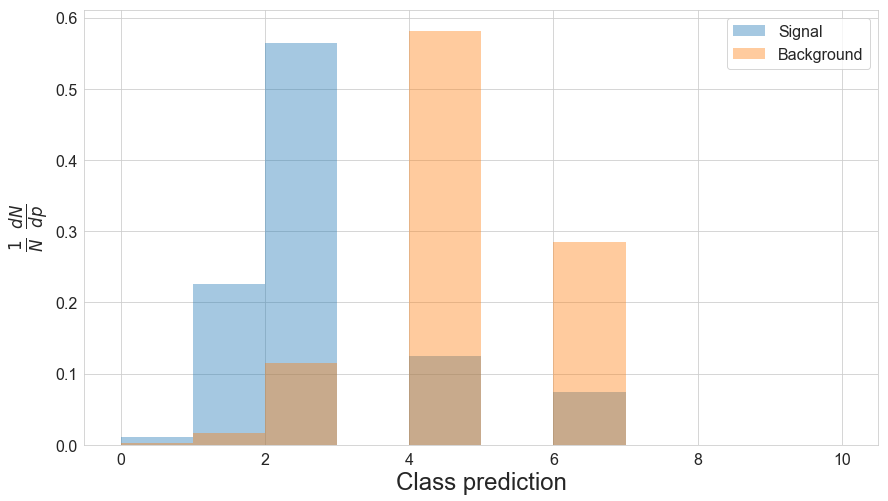

In [21]:
plot_preds(df, bin_edges=np.linspace(0,10,11))

In [22]:
bin_preds(df)

In [23]:
df.head()

,pred,gen_target,pred_bin
0,2,1.0,2
1,2,1.0,2
2,1,1.0,1
3,2,1.0,2
4,2,1.0,2


In [24]:
f_s,f_b = get_shape(df,1),get_shape(df,0)

In [25]:
f_s.sum(), f_b.sum()

(tensor(1.), tensor(1.))

In [26]:
f_s, f_b

(tensor([2.3666e-01, 5.6393e-01, 2.0000e-13, 1.2509e-01, 2.0000e-13, 7.4322e-02,
         2.0000e-13, 2.0000e-13, 2.0000e-13, 2.0000e-13]),
 tensor([1.9826e-02, 1.1442e-01, 2.0000e-13, 5.8161e-01, 2.0000e-13, 2.8414e-01,
         2.0000e-13, 2.0000e-13, 2.0000e-13, 2.0000e-13]))

In [27]:
asimov = (50*f_s)+(1000*f_b)

In [28]:
asimov, asimov.sum()

(tensor([3.1659e+01, 1.4262e+02, 2.1000e-10, 5.8786e+02, 2.1000e-10, 2.8786e+02,
         2.1000e-10, 2.1000e-10, 2.1000e-10, 2.1000e-10]), tensor(1050.))

In [29]:
n = 1050
x = np.linspace(20,80,61)
y = np.zeros_like(x)
for i,m in enumerate(x):
    pois = torch.distributions.Poisson((m*f_s)+(1000*f_b))
    y[i] = -pois.log_prob(asimov).sum()
y

array([15.95739746, 15.81438446, 15.6776886 , 15.54601288, 15.4206543 ,
       15.30010223, 15.18563843, 15.07636261, 14.9723587 , 14.8735733 ,
       14.7800827 , 14.69171906, 14.60839081, 14.53003693, 14.45652008,
       14.38809204, 14.32446289, 14.26543427, 14.21100616, 14.16165161,
       14.11634827, 14.07566833, 14.03983307, 14.00801849, 13.98085785,
       13.95825958, 13.93915558, 13.92468262, 13.91479492, 13.90838623,
       13.90647125, 13.90843964, 13.91454315, 13.92480469, 13.93822479,
       13.95616913, 13.9776001 , 14.00297546, 14.03214264, 14.06507111,
       14.10146332, 14.14187622, 14.18556976, 14.23300934, 14.28400421,
       14.33827209, 14.39592743, 14.45737457, 14.52210999, 14.59009552,
       14.66134644, 14.7360611 , 14.81375885, 14.89519501, 14.97980499,
       15.06716156, 15.15753937, 15.25190735, 15.348526  , 15.44857025,
       15.55138397])

In [30]:
y_tf2 = np.array([31.626238,31.466385,31.313095,31.166267,31.025808,30.891619,30.76361
,30.641693,30.525778,30.415783,30.31162,30.213215,30.120483,30.033348
,29.951736,29.875574,29.804789,29.739307,29.679066,29.623993,29.574026
,29.5291,29.489151,29.454117,29.423939,29.398558,29.377914,29.361954
,29.35062,29.343859,29.341618,29.343842,29.350483,29.36149,29.376812
,29.396404,29.420216,29.448202,29.480318,29.516518,29.556757,29.600994
,29.649185,29.70129,29.757267,29.817076,29.88068,29.948036,30.019108
,30.093859,30.17225,30.25425,30.339819,30.42892,30.521524,30.617598
,30.7171,30.820007,30.926281,31.035892,31.148808], dtype='float32')

In [31]:
y_tf2-y_tf2.min()

array([2.2846203e+00, 2.1247673e+00, 1.9714775e+00, 1.8246498e+00,
       1.6841908e+00, 1.5500011e+00, 1.4219933e+00, 1.3000755e+00,
       1.1841602e+00, 1.0741653e+00, 9.7000313e-01, 8.7159729e-01,
       7.7886581e-01, 6.9173050e-01, 6.1011887e-01, 5.3395653e-01,
       4.6317101e-01, 3.9768982e-01, 3.3744812e-01, 2.8237534e-01,
       2.3240852e-01, 1.8748283e-01, 1.4753342e-01, 1.1249924e-01,
       8.2321167e-02, 5.6940079e-02, 3.6296844e-02, 2.0336151e-02,
       9.0026855e-03, 2.2411346e-03, 0.0000000e+00, 2.2239685e-03,
       8.8653564e-03, 1.9872665e-02, 3.5194397e-02, 5.4786682e-02,
       7.8598022e-02, 1.0658455e-01, 1.3870049e-01, 1.7490005e-01,
       2.1513939e-01, 2.5937653e-01, 3.0756760e-01, 3.5967255e-01,
       4.1564941e-01, 4.7545815e-01, 5.3906250e-01, 6.0641861e-01,
       6.7749023e-01, 7.5224113e-01, 8.3063316e-01, 9.1263199e-01,
       9.9820137e-01, 1.0873032e+00, 1.1799068e+00, 1.2759800e+00,
       1.3754826e+00, 1.4783897e+00, 1.5846634e+00, 1.6942749e

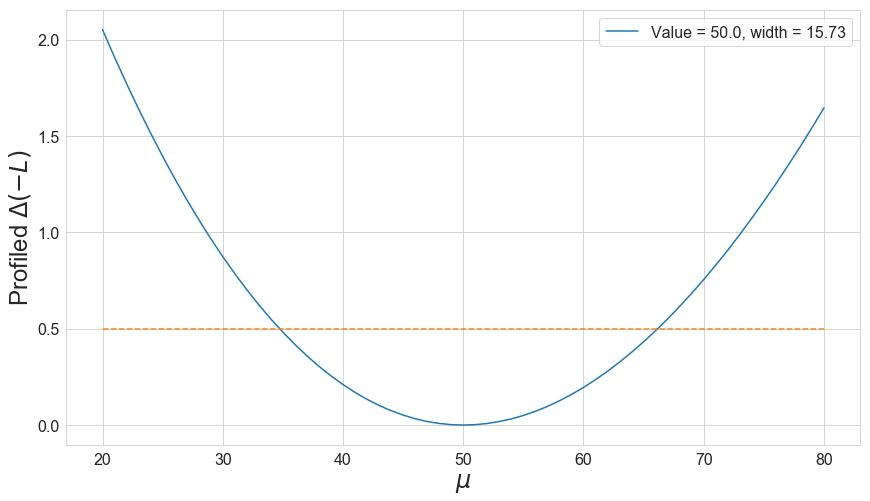

In [32]:
plot_likelihood(y-y.min())

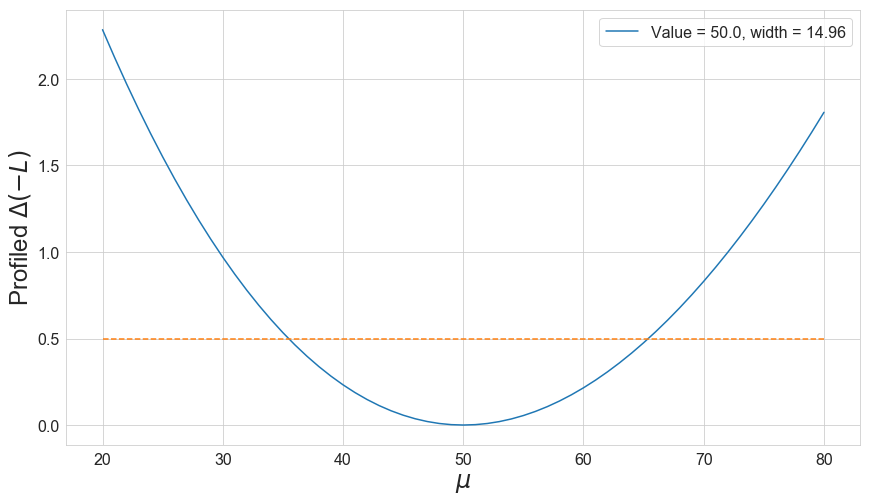

In [33]:
plot_likelihood(y_tf2-y_tf2.min())

# Nuisances - via interpolation

In [34]:
bkg = test.dataset.x[test.dataset.y.squeeze() == 0]
assert len(bkg) == 500000

In [35]:
b_shapes = get_paper_syst_shapes(bkg, df, model=model, pred_cb=InfernoPred())

Running: r=-0.2


Running: r=0


Running: r=0.2


Running: l=2.5


Running: l=3


Running: l=3.5


In [36]:
df

,pred,gen_target,pred_bin,pred_-0.2_3,pred_-0.2_3_bin,pred_0_3,pred_0_3_bin,pred_0.2_3,pred_0.2_3_bin,pred_0_2.5,pred_0_2.5_bin,pred_0_3.5,pred_0_3.5_bin
0,2,1.0,2,2,2,2,2,2,2,2,2,2,2
1,2,1.0,2,2,2,2,2,2,2,2,2,2,2
2,1,1.0,1,1,1,1,1,1,1,1,1,1,1
3,2,1.0,2,2,2,2,2,2,2,2,2,2,2
4,2,1.0,2,2,2,2,2,2,2,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,6,0.0,6,6,6,6,6,6,6,6,6,6,6
999996,6,0.0,6,6,6,6,6,4,4,6,6,6,6
999997,4,0.0,4,4,4,4,4,4,4,4,4,4,4
999998,2,0.0,2,2,2,2,2,6,6,6,6,2,2


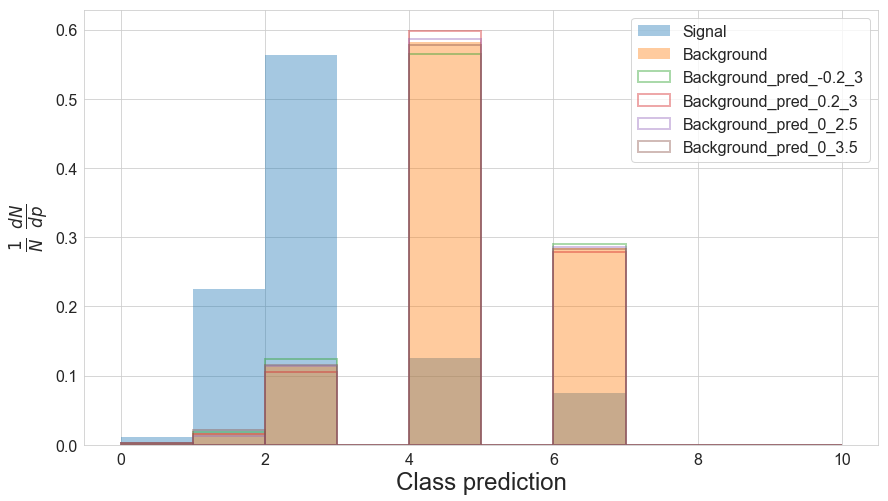

In [37]:
plot_preds(df, pred_names=['pred', 'pred_-0.2_3', 'pred_0.2_3', 'pred_0_2.5', 'pred_0_3.5'], bin_edges=np.linspace(0,10,11))

tensor([1.6684e-02, 1.2352e-01, 2.0000e-13, 5.6865e-01, 2.0000e-13, 2.9115e-01,
        2.0000e-13, 2.0000e-13, 2.0000e-13, 2.0000e-13])
tensor([2.1654e-02, 1.2422e-01, 2.0000e-13, 5.6437e-01, 2.0000e-13, 2.8976e-01,
        2.0000e-13, 2.0000e-13, 2.0000e-13, 2.0000e-13])
tensor([2.6550e-02, 1.2508e-01, 2.0000e-13, 5.6008e-01, 2.0000e-13, 2.8829e-01,
        2.0000e-13, 2.0000e-13, 2.0000e-13, 2.0000e-13])
tensor([1.4856e-02, 1.1372e-01, 2.0000e-13, 5.8589e-01, 2.0000e-13, 2.8553e-01,
        2.0000e-13, 2.0000e-13, 2.0000e-13, 2.0000e-13])
tensor([1.9826e-02, 1.1442e-01, 2.0000e-13, 5.8161e-01, 2.0000e-13, 2.8414e-01,
        2.0000e-13, 2.0000e-13, 2.0000e-13, 2.0000e-13])
tensor([2.4722e-02, 1.1529e-01, 2.0000e-13, 5.7732e-01, 2.0000e-13, 2.8267e-01,
        2.0000e-13, 2.0000e-13, 2.0000e-13, 2.0000e-13])
tensor([1.2764e-02, 1.0452e-01, 2.0000e-13, 6.0293e-01, 2.0000e-13, 2.7978e-01,
        2.0000e-13, 2.0000e-13, 2.0000e-13, 2.0000e-13])
tensor([1.7734e-02, 1.0522e-01, 2.0000e-1

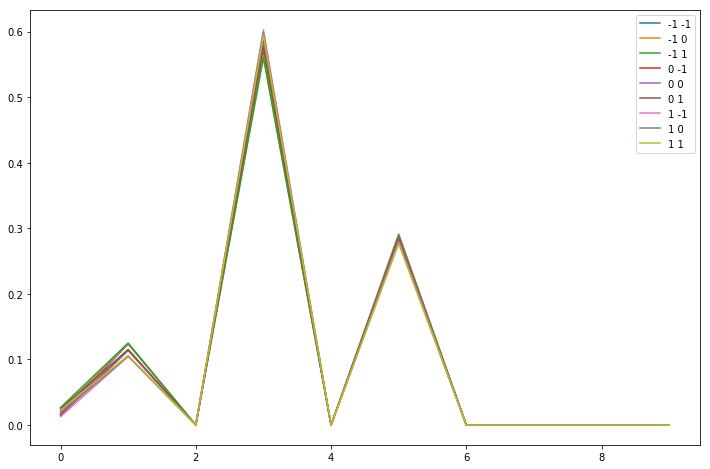

In [38]:
fig = plt.figure(figsize=(12,8))
for r in [-1,0,1]:
    for l in [-1,0,1]:
        alpha = Tensor((r,l))[None,:]
        s = interp_shape(alpha, **b_shapes).squeeze()
        print(s)
        plt.plot(s, label=f'{r} {l}')
plt.legend()

# Newton

In [39]:
profiler = partialler(calc_profile, n=1050, mu_scan=torch.linspace(20,80,61), true_mu=50)

## BM 1
r free, l fixed

In [40]:
bm1_b_shapes = OrderedDict([('f_b_nom', b_shapes['f_b_nom']),
                            ('f_b_up',  b_shapes['f_b_up'][0][None,:]),
                            ('f_b_dw',  b_shapes['f_b_dw'][0][None,:])])

In [41]:
bm1_b_shapes['f_b_up'].shape

torch.Size([1, 10])

In [42]:
nll = profiler(f_s=f_s, n_steps=100, **bm1_b_shapes)

Linear regime: Mu 20.0, alpha tensor([-1.1144])
Linear regime: Mu 21.0, alpha tensor([-1.0761])
Linear regime: Mu 22.0, alpha tensor([-1.0378])
Linear regime: Mu 78.0, alpha tensor([1.0151])
Linear regime: Mu 79.0, alpha tensor([1.0505])
Linear regime: Mu 80.0, alpha tensor([1.0857])


In [43]:
nll = to_np(nll)

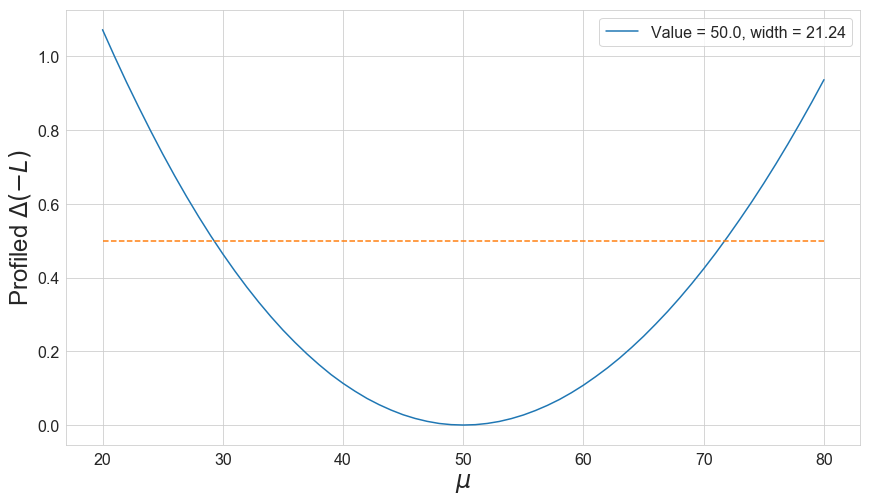

In [44]:
plot_likelihood(nll-nll.min())

## BM 1l
r fixed, l free

In [45]:
bm1l_b_shapes = OrderedDict([('f_b_nom', b_shapes['f_b_nom']),
                             ('f_b_up',  b_shapes['f_b_up'][1][None,:]),
                             ('f_b_dw',  b_shapes['f_b_dw'][1][None,:])])

In [46]:
nll = profiler(f_s=f_s, n_steps=100, **bm1l_b_shapes)

Linear regime: Mu 20.0, alpha tensor([1.4629])
Linear regime: Mu 21.0, alpha tensor([1.4137])
Linear regime: Mu 22.0, alpha tensor([1.3645])
Linear regime: Mu 23.0, alpha tensor([1.3153])
Linear regime: Mu 24.0, alpha tensor([1.2662])
Linear regime: Mu 25.0, alpha tensor([1.2171])
Linear regime: Mu 26.0, alpha tensor([1.1681])
Linear regime: Mu 27.0, alpha tensor([1.1190])
Linear regime: Mu 28.0, alpha tensor([1.0701])
Linear regime: Mu 29.0, alpha tensor([1.0211])
Linear regime: Mu 72.0, alpha tensor([-1.0305])
Linear regime: Mu 73.0, alpha tensor([-1.0771])
Linear regime: Mu 74.0, alpha tensor([-1.1238])
Linear regime: Mu 75.0, alpha tensor([-1.1704])
Linear regime: Mu 76.0, alpha tensor([-1.2170])
Linear regime: Mu 77.0, alpha tensor([-1.2636])
Linear regime: Mu 78.0, alpha tensor([-1.3102])
Linear regime: Mu 79.0, alpha tensor([-1.3567])
Linear regime: Mu 80.0, alpha tensor([-1.4033])


In [47]:
nll = to_np(nll)

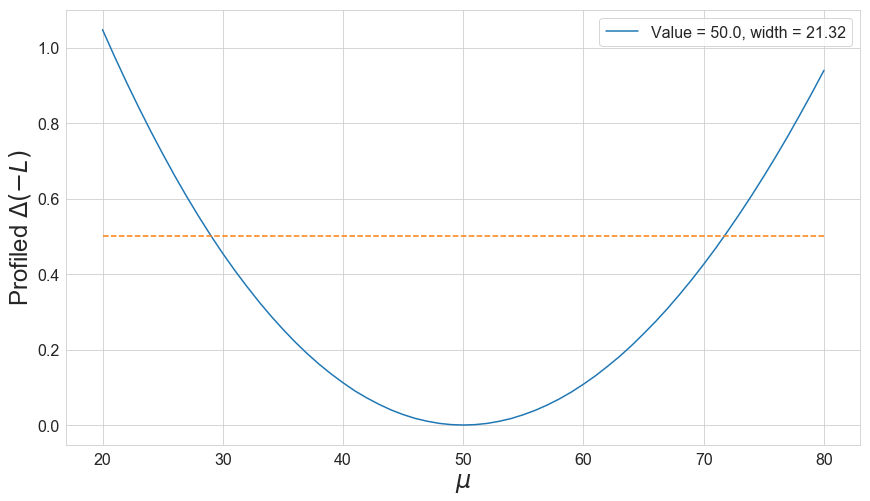

In [48]:
plot_likelihood(nll-nll.min())

## BM 2

In [49]:
nll = profiler(f_s=f_s, n_steps=100, **b_shapes)

Linear regime: Mu 20.0, alpha tensor([-0.7750,  1.0207])


In [50]:
nll = to_np(nll)

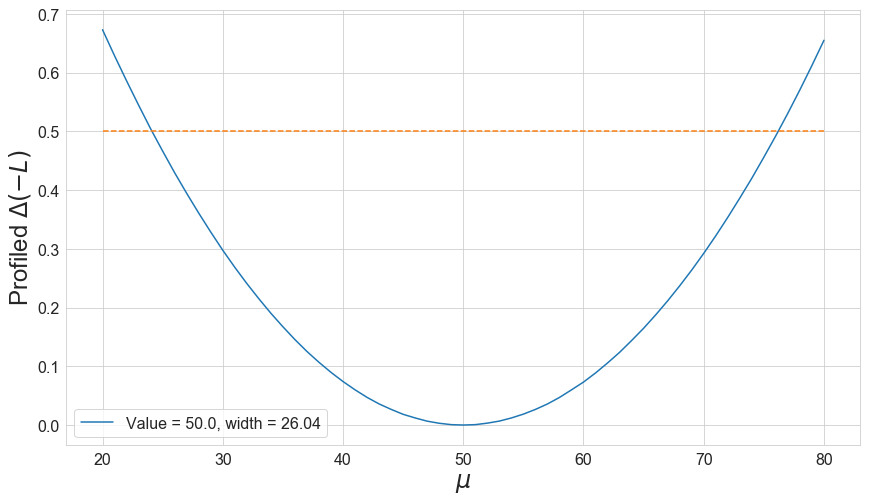

In [51]:
plot_likelihood(nll-nll.min())